**Input + Initializations**


In [9]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'Horizontal_Format.xlsx'
data = pd.read_excel(file_path)

print(data.head())
print("Columns:", data.columns)

transaction_id_col = 'TiD' 
items_col = 'items'

#Used to FILTER items into indvisual letters/objects 
transactions = data[items_col].apply(lambda x: x.split(','))  

# Prepare transactions as a list of lists with transaction IDs
processed_data = list(zip(data[transaction_id_col], transactions))

min_support = float(input("Enter the minimum support count (e.g., 2): "))
min_confidence = float(input("Enter the minimum confidence threshold (e.g., 0.8): "))
    
    # Validate inputs
if min_support <= 0:
    raise ValueError("Minimum support count must be greater than 0.")
if not (0 < min_confidence <= 1):
    raise ValueError("Minimum confidence must be between 0 and 1.")
s = min_support * len(data)

   TiD        items
0    1  M,O,N,K,E,Y
1    2  D,O,N,K,E,Y
2    3      M,A,K,E
3    4    M,U,C,K,Y
4    5  C,O,O,K,I,E
Columns: Index(['TiD', 'items'], dtype='object')


**Calculate the Lift and Strong rules**


In [10]:
from itertools import combinations

def get_subsets(itemset):
    """Generates all non-empty proper subsets of the given itemset."""
    subsets = []
    for r in range(1, len(itemset)):
        subsets.extend(combinations(itemset, r))  # Generate all r-sized combinations
    return [frozenset(subset) for subset in subsets]  # Convert tuples to frozensets

def calculate_confidence_and_lift(l, pl, min_support, min_confidence, total_transactions):
    strong_rules = []
    
    # Iterate through each frequent itemset in L
    for itemset in l:
        # We only care about itemsets with size >= 2
        if len(itemset) >= 2:
            # Generate all possible antecedents (non-empty proper subsets)
            for r in range(1, len(itemset)):
                antecedents = combinations(itemset, r)
                for antecedent_tuple in antecedents: 
                    antecedent = frozenset(antecedent_tuple)
                    consequent = itemset - antecedent

                    support_count_antecedent = pl.get(antecedent, 0)
                    support_count_consequent = pl.get(consequent, 0)
                    support_count_full = l[itemset]
                    
                    print(f"Itemset: {list(itemset)}")
                    print(f"Antecedent: {list(antecedent)} -> Consequent: {list(consequent)}")
                    print(f"Support(Full): {support_count_full}, Support(Antecedent): {support_count_antecedent}, Support(Consequent): {support_count_consequent}")
                    
                    # Confidence calculation: support(A ∪ B) / support(A)
                    if support_count_antecedent > 0:
                        confidence = support_count_full / support_count_antecedent
                    else:
                        confidence = 0

                    # Lift calculation: support(A ∪ B) / (support(A) * support(B))
                    if support_count_antecedent > 0 and support_count_consequent > 0:
                        lift = (support_count_full * total_transactions) / (support_count_antecedent * support_count_consequent)
                    else:
                        lift = 0

                    print(f"Confidence: {confidence:.4f}, Lift: {lift:.4f}")
                    print("-" * 50)

                    # Strong Rule Definition
                    if confidence >= min_confidence and support_count_full >= min_support:
                        strong_rules.append((antecedent, consequent, confidence, lift))

    return strong_rules


**Visualization Function**


In [11]:
def Visualization(counter, title):
    items = ['-'.join(list(key)) if isinstance(key, frozenset) else key for key in counter.keys()]
    counts = list(counter.values())
    
    plt.bar(items, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Itemsets")
    plt.ylabel("Counts")
    plt.xticks(rotation=45, ha="right")
    plt.show()

**Visualization**

C1:
['M']: 3
['O']: 4
['N']: 2
['K']: 5
['E']: 4
['Y']: 3
['D']: 1
['A']: 1
['U']: 1
['C']: 2
['I']: 1



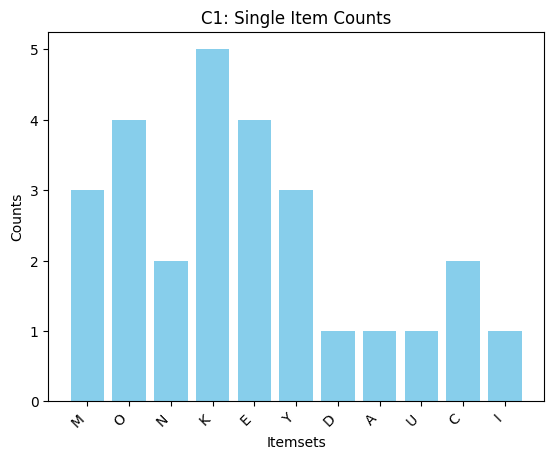

In [12]:
c = Counter()

# Count occurrences of each item
for transaction in processed_data:
    for item in transaction[1]:
        c[item.strip()] += 1  # Use .strip() to clean up extra spaces

print("C1:")
for i in c:
    print(str([i]) + ": " + str(c[i]))
print()

# Visualize C1
Visualization(c, "C1: Single Item Counts")


L1:
['M']: 3
['O']: 3
['K']: 5
['E']: 4
['Y']: 3



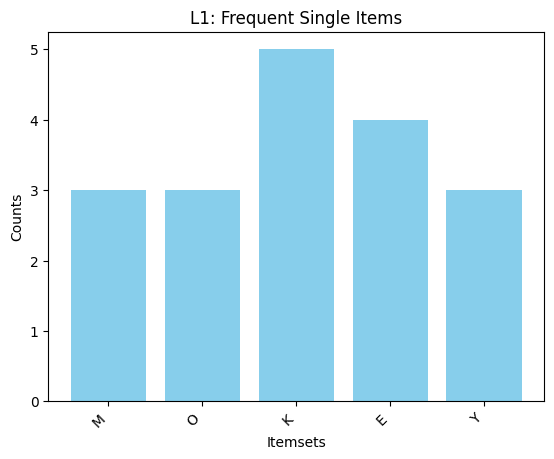

In [13]:
l = Counter()
for item in c:
    count = 0
    for _, transaction_items in processed_data:
        # avoid duplicate counts by setting the transactions to a set
        transaction_set = set(transaction_items)
        # check if the item exists in the transaction
        if frozenset([item]).issubset(transaction_set):  
            count += 1
    
    # check on l support
    if count >= s:
        l[frozenset([item])] += count

print("L1:")
for i in l:
    print(str(list(i)) + ": " + str(l[i]))
print()


Visualization(l, "L1: Frequent Single Items")


C2:
['Y', 'M']: 2
['E', 'M']: 2
['Y', 'K']: 3
['Y', 'E']: 2
['M', 'K']: 3
['O', 'E']: 3
['O', 'Y']: 2
['E', 'K']: 4
['O', 'M']: 1
['O', 'K']: 3



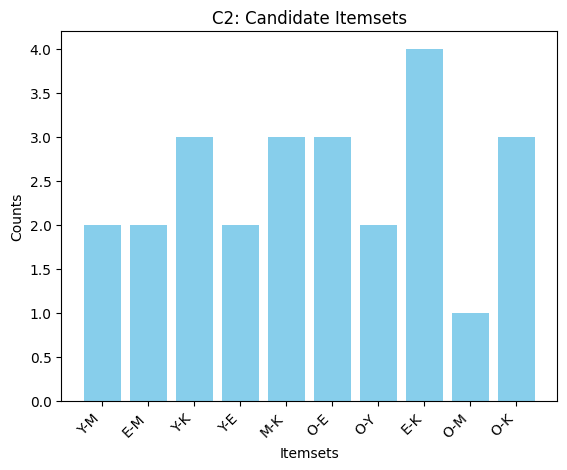

L2:
['Y', 'K']: 3
['M', 'K']: 3
['O', 'E']: 3
['E', 'K']: 4
['O', 'K']: 3



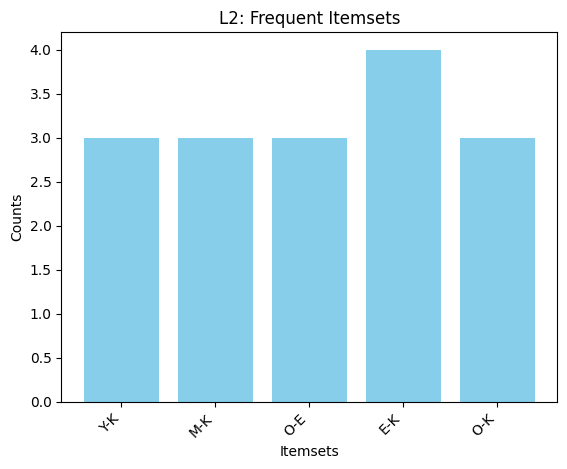

Itemset: ['Y', 'K']
Antecedent: ['Y'] -> Consequent: ['K']
Support(Full): 3, Support(Antecedent): 3, Support(Consequent): 5
Confidence: 1.0000, Lift: 1.0000
--------------------------------------------------
Itemset: ['Y', 'K']
Antecedent: ['K'] -> Consequent: ['Y']
Support(Full): 3, Support(Antecedent): 5, Support(Consequent): 3
Confidence: 0.6000, Lift: 1.0000
--------------------------------------------------
Itemset: ['M', 'K']
Antecedent: ['M'] -> Consequent: ['K']
Support(Full): 3, Support(Antecedent): 3, Support(Consequent): 5
Confidence: 1.0000, Lift: 1.0000
--------------------------------------------------
Itemset: ['M', 'K']
Antecedent: ['K'] -> Consequent: ['M']
Support(Full): 3, Support(Antecedent): 5, Support(Consequent): 3
Confidence: 0.6000, Lift: 1.0000
--------------------------------------------------
Itemset: ['O', 'E']
Antecedent: ['O'] -> Consequent: ['E']
Support(Full): 3, Support(Antecedent): 3, Support(Consequent): 4
Confidence: 1.0000, Lift: 1.2500
-----------

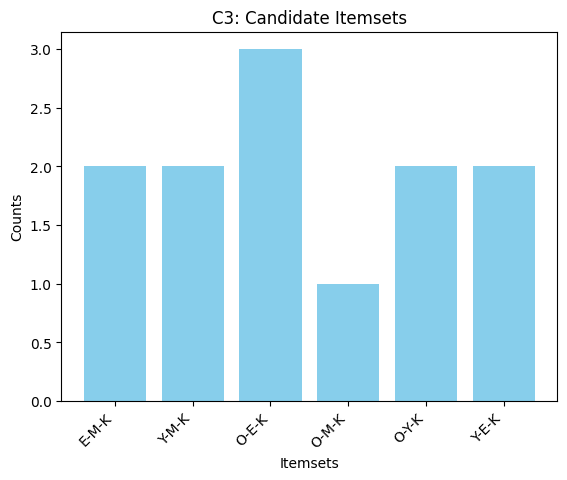

L3:
['O', 'E', 'K']: 3



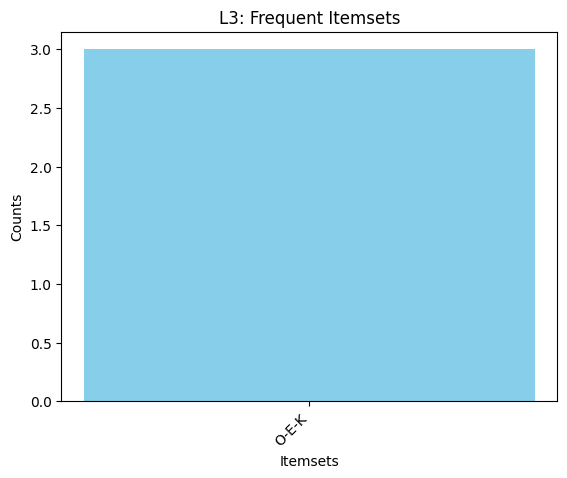

Itemset: ['O', 'E', 'K']
Antecedent: ['O'] -> Consequent: ['E', 'K']
Support(Full): 3, Support(Antecedent): 3, Support(Consequent): 4
Confidence: 1.0000, Lift: 1.2500
--------------------------------------------------
Itemset: ['O', 'E', 'K']
Antecedent: ['E'] -> Consequent: ['O', 'K']
Support(Full): 3, Support(Antecedent): 4, Support(Consequent): 3
Confidence: 0.7500, Lift: 1.2500
--------------------------------------------------
Itemset: ['O', 'E', 'K']
Antecedent: ['K'] -> Consequent: ['O', 'E']
Support(Full): 3, Support(Antecedent): 5, Support(Consequent): 3
Confidence: 0.6000, Lift: 1.0000
--------------------------------------------------
Itemset: ['O', 'E', 'K']
Antecedent: ['O', 'E'] -> Consequent: ['K']
Support(Full): 3, Support(Antecedent): 3, Support(Consequent): 5
Confidence: 1.0000, Lift: 1.0000
--------------------------------------------------
Itemset: ['O', 'E', 'K']
Antecedent: ['O', 'K'] -> Consequent: ['E']
Support(Full): 3, Support(Antecedent): 3, Support(Consequen

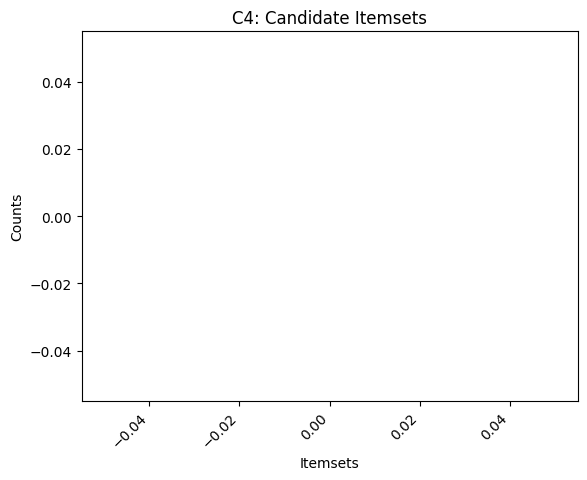

L4:



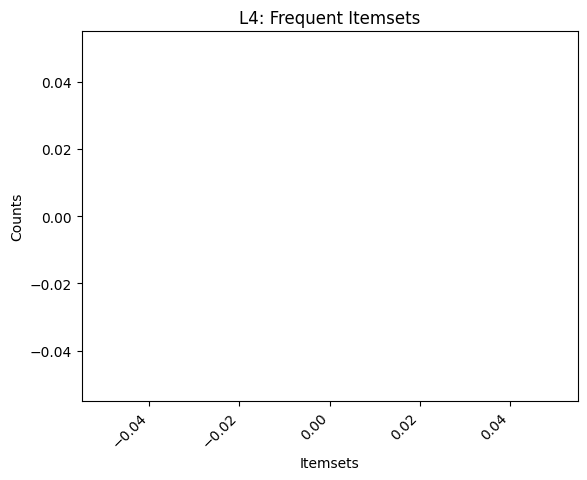

No strong rules found for L4


In [14]:
pl = l  # previous frequent itemsets
pos = 1  # counter for iterations

for count in range(2, 1000):  # max iterations set to 1000 for safety
    
    # get candidate itemsets of size count
    nc = set()
    temp = list(l)
    for i in range(len(temp)):
        for j in range(i + 1, len(temp)):
            t = temp[i].union(temp[j])
            if len(t) == count:
                nc.add(t)

    nc = list(nc)
    
    # count occurrences of the candidate
    c = Counter()
    for candidate in nc:
        c[candidate] = 0
        # iterate through processed transactions
        for _, transaction_items in processed_data:
            transaction_set = set(transaction_items)  # Remove duplicates within the transaction
            if candidate.issubset(transaction_set):
                c[candidate] += 1

    # display candidate itemsets
    print(f"C{count}:")
    for itemset, cnt in c.items():
        print(f"{list(itemset)}: {cnt}")
    print()

    Visualization(c, f"C{count}: Candidate Itemsets")

    # filter itemsets based on min_support
    l = Counter()
    for itemset, cnt in c.items():
        if cnt >= s:
            l[itemset] = cnt
    # display frequent itemsets
    print(f"L{count}:")
    for itemset, cnt in l.items():
        print(f"{list(itemset)}: {cnt}")
    print()

    # visualize frequent itemsets
    Visualization(l, f"L{count}: Frequent Itemsets")
    rules = calculate_confidence_and_lift(l, pl, min_support, min_confidence, len(data))
    if rules:
        print(f"Strong Rules and Lift (L{count}):")
        for antecedent, consequent, confidence, lift in rules:
            print(f"Rule: {list(antecedent)} -> {list(consequent)}, Confidence: {confidence:.2f}, Lift: {lift:.2f}\n")
    else:
        print(f"No strong rules found for L{count}")
    # stop if no frequent itemsets remain
    if len(l) == 0:
        break

    pl.update(l) # update previous frequent itemsets
    pos = count  # update iteration counter


Result:
L1, L2, L3:
['M']: 3
['O']: 3
['K']: 5
['E']: 4
['Y']: 3
['Y', 'K']: 3
['M', 'K']: 3
['O', 'E']: 3
['E', 'K']: 4
['O', 'K']: 3
['O', 'E', 'K']: 3



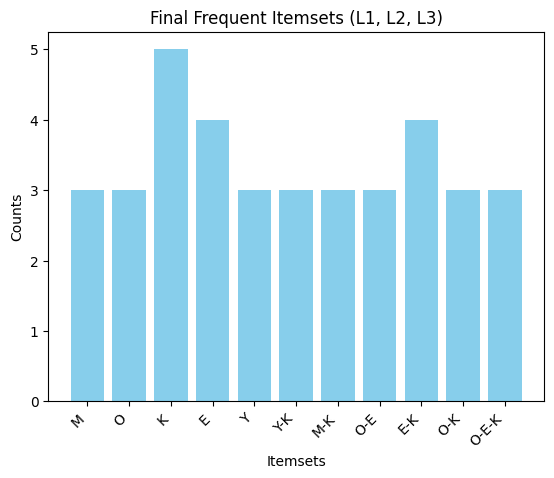

In [15]:
print("Result:")
print("L1, L2, L3:")
for i in pl:
    print(str(list(i)) + ": " + str(pl[i]))
print()

Visualization(pl, f"Final Frequent Itemsets (L1, L2, L3)")